# Visual Relationship Detection Dataset
[Website](https://cs.stanford.edu/people/ranjaykrishna/vrd/)

In [1]:
%matplotlib inline
import io
import json
from itertools import chain

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from itertools import zip_longest
from IPython.display import display, Markdown, HTML

vrd_dir = Path('../../data/raw/vrd/')

## Data loading

### Objects, actions, interactions

In [2]:
with vrd_dir.joinpath('objects.json').open() as f:
    objects = pd.Series(json.load(f), name='objects')

l = [f'{idx:2} {name:15}' for idx, name in enumerate(objects)]
for row in zip_longest(*np.array_split(l, 4), fillvalue=''):
    print(*row)

 0 person          25 clock           50 airplane        75 refrigerator   
 1 sky             26 bag             51 sofa            76 cart           
 2 building        27 shoe            52 cup             77 skis           
 3 truck           28 laptop          53 sink            78 pot            
 4 bus             29 desk            54 shelf           79 surfboard      
 5 table           30 cabinet         55 box             80 paper          
 6 shirt           31 counter         56 van             81 mouse          
 7 chair           32 bench           57 hand            82 trash can      
 8 car             33 shoes           58 shorts          83 cone           
 9 train           34 tower           59 post            84 camera         
10 glasses         35 bottle          60 jeans           85 ball           
11 tree            36 helmet          61 cat             86 bear           
12 boat            37 stove           62 sunglasses      87 giraffe        
13 hat      

In [3]:
with vrd_dir.joinpath('predicates.json').open() as f:
    predicates = pd.Series(json.load(f), name='predicates')

l = [f'{idx:2} {name:15}' for idx, name in enumerate(predicates)]
for row in zip_longest(*np.array_split(l, 4), fillvalue=''):
    print(*row)

 0 on              18 near            36 carry           53 eat            
 1 wear            19 walk to         37 look            54 park on        
 2 has             20 walk            38 stand on        55 lying on       
 3 next to         21 walk past       39 use             56 pull           
 4 sleep next to   22 in              40 at              57 talk           
 5 sit next to     23 below           41 attach to       58 lean on        
 6 stand next to   24 beside          42 cover           59 fly            
 7 park next       25 walk beside     43 touch           60 face           
 8 walk next to    26 over            44 watch           61 play with      
 9 above           27 hold            45 against         62 sleep on       
10 behind          28 by              46 inside          63 outside of     
11 stand behind    29 beneath         47 adjacent to     64 rest on        
12 sit behind      30 with            48 across          65 follow         
13 park behi

Format of `annotations_train.json`:
```
[...
    FILENAME: [...
        {'subject': {'category': CATEGORY_ID, 'bbox': [YMIN, YMAX, XMIN, XMAX]},
         'predicate': PREDICATE_ID,
         'object': {'category': CATEGORY_ID, 'bbox': [YMIN, YMAX, XMIN, XMAX]},
        }
        ...]
    ...]
```

In [4]:
with vrd_dir.joinpath('annotations_train.json').open() as f:
    train_annotations = json.load(f)
print('Train images:', len(train_annotations))

def y1y2x1x2_to_x1y1x2y2(y1y2x1x2):
    y1, y2, x1, x2 = y1y2x1x2
    return x1, y1, x2, y2

df = []
for filename, annotations in train_annotations.items():
    for a in annotations:
        df.append({
            'filename': filename,
            'subj_class': a['subject']['category'],
            'pred_class': a['predicate'],
            'obj_class': a['object']['category'],
            'subj_box': y1y2x1x2_to_x1y1x2y2(a['subject']['bbox']),
            'obj_box': y1y2x1x2_to_x1y1x2y2(a['object']['bbox']),
        })
df = pd.DataFrame(df)
print('Images with at least one annotation:', df.filename.nunique())

df = pd.merge(df, objects.rename('subj_str'), left_on='subj_class', right_index=True)
df = pd.merge(df, predicates.rename('pred_str'), left_on='pred_class', right_index=True)
df = pd.merge(df, objects.rename('obj_str'), left_on='obj_class', right_index=True)
df = df.sort_values('filename').reset_index(drop=True)

df

Train images: 4000
Images with at least one annotation: 3780


,filename,subj_class,pred_class,obj_class,subj_box,obj_box,subj_str,pred_str,obj_str
0,10003464684_a0d445a4fb_b.jpg,0,1,10,"(160, 189, 218, 273)","(165, 215, 210, 234)",person,wear,glasses
1,10003464684_a0d445a4fb_b.jpg,0,1,10,"(333, 256, 403, 363)","(347, 283, 387, 297)",person,wear,glasses
2,10003464684_a0d445a4fb_b.jpg,0,1,10,"(749, 217, 838, 366)","(776, 243, 814, 259)",person,wear,glasses
3,10003464684_a0d445a4fb_b.jpg,0,2,84,"(230, 124, 309, 228)","(261, 139, 285, 155)",person,has,camera
4,10003464684_a0d445a4fb_b.jpg,0,18,40,"(326, 280, 560, 718)","(554, 262, 1021, 764)",person,near,bed
...,...,...,...,...,...,...,...,...,...
30350,9995825294_cd1c8ac70f_b.jpg,34,2,25,"(223, 269, 535, 863)","(349, 383, 468, 510)",tower,has,clock
30351,9995825294_cd1c8ac70f_b.jpg,14,14,1,"(1, 814, 246, 1023)","(1, 1, 682, 1024)",trees,in the front of,sky
30352,9995825294_cd1c8ac70f_b.jpg,34,14,1,"(214, 51, 680, 1023)","(1, 1, 682, 1024)",tower,in the front of,sky
30353,9995825294_cd1c8ac70f_b.jpg,34,2,25,"(214, 51, 680, 1023)","(349, 383, 468, 510)",tower,has,clock


## Statistics

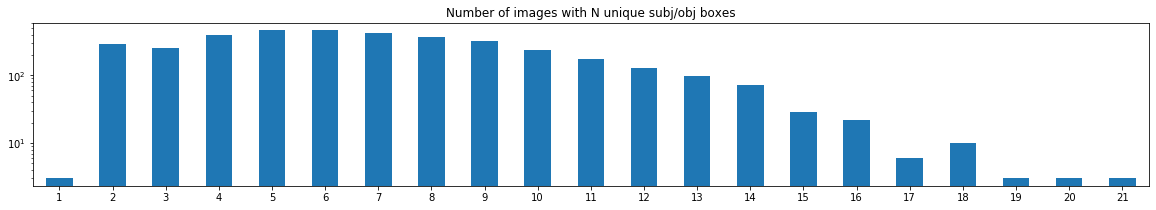

In [5]:
s = df.groupby('filename').apply(lambda g: len(set(chain(g.subj_box, g.obj_box))))
ax = s.value_counts() \
  .reindex(np.arange(1, s.max() + 1), fill_value=0) \
  .plot.bar(logy=True, figsize=(20, 3), rot=0) \
  .set_title('Number of images with N unique subj/obj boxes')

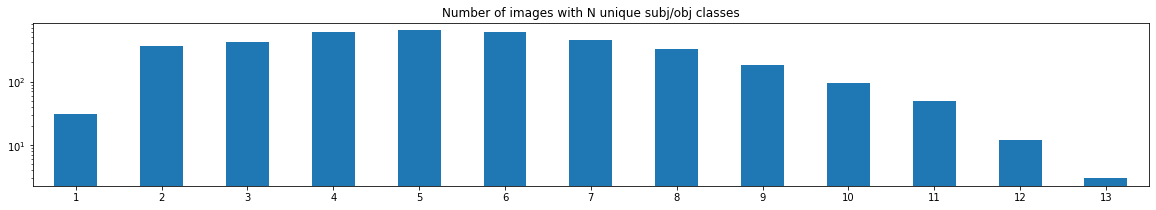

In [6]:
s = df.groupby('filename').apply(lambda g: len(set(chain(g.subj_str, g.obj_str))))
ax = s.value_counts() \
  .reindex(np.arange(1, s.max() + 1), fill_value=0) \
  .plot.bar(logy=True, figsize=(20, 3), rot=0) \
  .set_title('Number of images with N unique subj/obj classes')

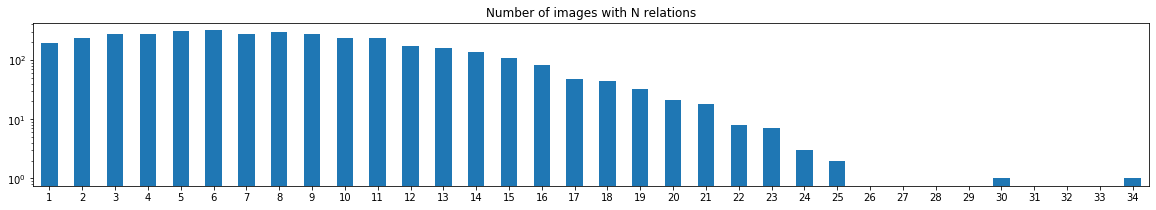

In [7]:
s = df.groupby('filename').size()
s.value_counts() \
  .reindex(np.arange(1, s.max()+1), fill_value=0) \
  .plot.bar(logy=True, figsize=(20, 3), rot=0) \
  .set_title('Number of images with N relations');

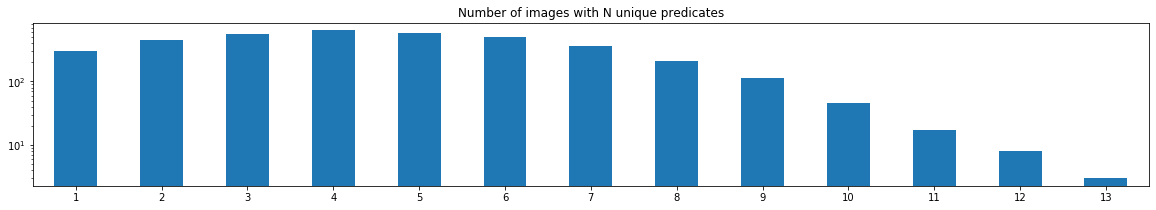

In [8]:
s = df.groupby('filename').pred_class.nunique()
ax = s.value_counts() \
  .reindex(np.arange(1, s.max() + 1), fill_value=0) \
  .plot.bar(logy=True, figsize=(20, 3), rot=0) \
  .set_title('Number of images with N unique predicates');

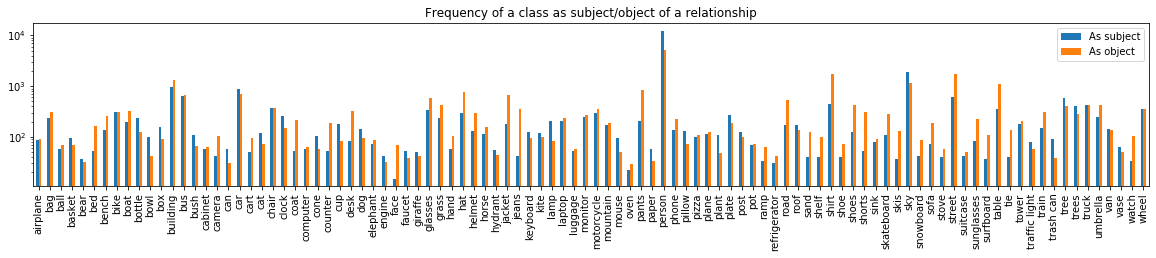

In [9]:
df[['subj_str', 'obj_str']] \
  .rename(columns={'subj_str': 'As subject', 'obj_str': 'As object'}) \
  .apply(pd.Series.value_counts) \
  .plot.bar(logy=True, figsize=(20, 3)) \
  .set_title('Frequency of a class as subject/object of a relationship');

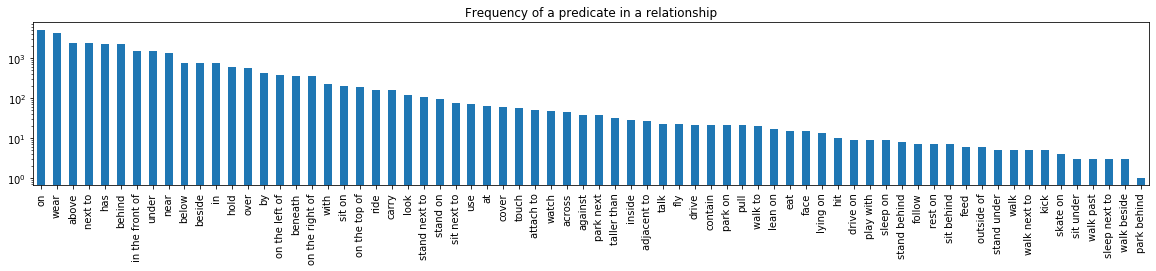

In [10]:
df.pred_str \
  .rename('Predicates') \
  .value_counts() \
  .plot.bar(logy=True, figsize=(20, 3)) \
  .set_title('Frequency of a predicate in a relationship');

## Problems

Some images contain duplicate annotations, i.e. `(subj, pred, obj)` classes correspond and also `(subj_box, obj_box)` are the same.

In [11]:
df_img = df.query("filename == '7463848344_8eec77148c_b.jpg'").copy()
df_img['duplicated'] = df_img.duplicated(['subj_str', 'pred_str', 'obj_str', 'subj_box', 'obj_box']).map(['', '<--'].__getitem__)
df_img \
    .drop(columns=['filename', 'subj_class', 'pred_class', 'obj_class']) \
    .sort_values(['subj_str', 'pred_str', 'obj_str', 'subj_box', 'obj_box']) \
    .set_index(['subj_str', 'pred_str', 'obj_str'])

subj_box                obj_box  \
subj_str   pred_str obj_str                                                    
person     has      skateboard     (239, 2, 858, 749)   (527, 502, 768, 760)   
           hold     skateboard   (794, 240, 871, 506)   (804, 375, 857, 515)   
                    skateboard   (794, 240, 871, 506)   (804, 375, 857, 515)   
                    skateboard   (794, 240, 871, 506)   (804, 375, 857, 515)   
                    skateboard   (794, 240, 871, 506)   (804, 375, 857, 515)   
                    skateboard   (794, 240, 871, 506)   (804, 375, 857, 515)   
           next to  skateboard     (239, 2, 858, 749)   (527, 502, 768, 760)   
           on       skateboard     (239, 2, 858, 749)   (527, 502, 768, 760)   
           watch    person       (794, 240, 871, 506)     (239, 2, 858, 749)   
                    person       (794, 240, 871, 506)     (239, 2, 858, 749)   
                    person       (794, 240, 871, 506)     (239, 2, 858, 749)   
                    person       (794, 240, 871, 506)     (239, 2, 858, 749)   
                    person       (794, 240, 871, 506)     (239, 2, 858, 749)   
           wear     hat         (952, 159, 1021, 482)  (979, 164, 1018, 184)   
                    hat         (952, 159, 1021, 482)  (979, 164, 1018, 184)   
                    hat         (952, 159, 1021, 482)  (979, 164, 1018, 184)   
                    hat         (952, 159, 1021, 482)  (979, 164, 1018, 184)   
                    hat         (952, 159, 1021, 482)  (979, 164, 1018, 184)   
                    jeans        (794, 240, 871, 506)   (791, 364, 856, 511)   
                    jeans        (794, 240, 871, 506)   (791, 364, 856, 511)   
                    jeans        (794, 240, 871, 506)   (791, 364, 856, 511)   
                    jeans        (794, 240, 871, 506)   (791, 364, 856, 511)   
                    pants          (239, 2, 858, 749)   (428, 290, 749, 629)   
                    shirt        (794, 240, 871, 506)   (789, 275, 881, 407)   
                    shirt        (794, 240, 871, 506)   (789, 275, 881, 407)   
                    shirt        (794, 240, 871, 506)   (789, 275, 881, 407)   
                    shirt        (794, 240, 871, 506)   (789, 275, 881, 407)   
                    shirt        (794, 240, 871, 506)   (789, 275, 881, 407)   
                    shirt       (952, 159, 1021, 482)  (958, 215, 1020, 328)   
                    shirt       (952, 159, 1021, 482)  (958, 215, 1020, 328)   
                    shirt       (952, 159, 1021, 482)  (958, 215, 1020, 328)   
                    shirt       (952, 159, 1021, 482)  (958, 215, 1020, 328)   
                    shirt       (952, 159, 1021, 482)  (958, 215, 1020, 328)   
skateboard below    person       (527, 502, 768, 760)     (239, 2, 858, 749)   

                               duplicated  
subj_str   pred_str obj_str                
person     has      skateboard             
           hold     skateboard             
                    skateboard        <--  
                    skateboard        <--  
                    skateboard        <--  
                    skateboard        <--  
           next to  skateboard             
           on       skateboard             
           watch    person                 
                    person            <--  
                    person            <--  
                    person            <--  
                    person            <--  
           wear     hat                    
                    hat               <--  
                    hat               <--  
                    hat               <--  
                    hat               <--  
                    jeans                  
                    jeans             <--  
                    jeans             <--  
                    jeans             <--  
                    pants                  
                    shirt                  
                    

How many non-duplicated relations are present in the dataset?

Unique:  29861
Total:   30355
          98.4%


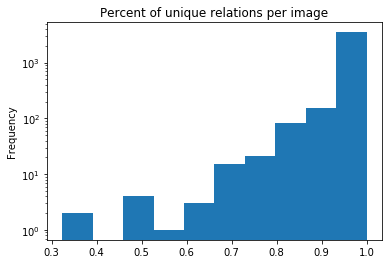

In [12]:
df_unique = df.drop_duplicates(['filename', 'subj_class', 'pred_class', 'obj_class', 'subj_box', 'obj_box'])
print(f'Unique: {len(df_unique):>6}') 
print(f'Total:  {len(df):>6}', )
print(f'{len(df_unique)/len(df):>15.1%}')

def percent_unique(df_img):
    df_clean = df_img.drop_duplicates(['subj_class', 'pred_class', 'obj_class', 'subj_box', 'obj_box'])
    return len(df_clean) / len(df_img)
df.groupby('filename').apply(percent_unique).plot.hist(logy=True, title='Percent of unique relations per image');

## Some images

In [13]:
def show_all(filename):
    img = cv2.cvtColor(
        cv2.imread((vrd_dir / 'sg_train_images' / filename).as_posix()), 
        cv2.COLOR_BGR2RGB
    )
    
    df_img = df.query(f'filename == "{filename}"') \
               .drop(columns='filename') \
               .sort_values(['subj_class', 'pred_class', 'obj_class'])
    
    display(Markdown(f'Image: {filename}'))
    display(
        df_img
        .drop(columns=['subj_class', 'pred_class', 'obj_class'])
        .set_index(['subj_str', 'pred_str', 'obj_str'])
    )
    
    if len(df_img) > 15:
        display(Markdown(f'Displaying only 8 relationships out of {len(df_img)}'))
        rg = np.random.default_rng(0)
        idx = rg.choice(len(df_img), replace=False, size=8)
        df_img = df_img.iloc[idx].sort_values(['subj_class', 'pred_class', 'obj_class'])
            
    ncols = min(1 + len(df_img), 3)
    nrows = int(np.ceil(len(df_img) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 8 * nrows), squeeze=False)
    
    ax = axes.flat[0]
    ax.imshow(img)
    ax.set_title(f'{filename} {img.shape[1]} x {img.shape[0]}')
    
    for interaction, ax in zip(df_img.itertuples(), axes.flat[1:]):
        ax.imshow(img)
        ax.set_title(f'{interaction.subj_str} {interaction.pred_str} {interaction.obj_str}')
        ax.add_artist(plt.Rectangle(
            [interaction.subj_box[0], interaction.subj_box[1]],
            width=interaction.subj_box[2] - interaction.subj_box[0], 
            height=interaction.subj_box[3] - interaction.subj_box[1],
            fill=False,
            linewidth=5,
            color='blue'
        ))
        ax.add_artist(plt.Rectangle(
            [interaction.obj_box[0], interaction.obj_box[1]],
            width=interaction.obj_box[2] - interaction.obj_box[0], 
            height=interaction.obj_box[3] - interaction.obj_box[1],
            fill=False,
            linewidth=5,
            color='red'
        ))
    
    for ax in axes.flat:
        ax.set_axis_off()
    
    # Prevent embedding these images in the notebook
    save_path = Path(filename).with_suffix('.jpg')
    buff = io.BytesIO()
    fig.savefig(buff, format='png', facecolor='white', bbox_inches='tight')
    Image.open(buff).convert('RGB').save(save_path, 'JPEG')
    buff.close()
    plt.close(fig)
    display(Markdown(f'![{filename}]({save_path})'))

Image with the highest number of relations, and also the highest number of duplicates.

In [14]:
show_all(df.groupby('filename').size().idxmax())

Image: 7463848344_8eec77148c_b.jpg

subj_box                obj_box
subj_str   pred_str obj_str                                                 
person     on       skateboard     (239, 2, 858, 749)   (527, 502, 768, 760)
           wear     shirt       (952, 159, 1021, 482)  (958, 215, 1020, 328)
                    shirt       (952, 159, 1021, 482)  (958, 215, 1020, 328)
                    shirt       (952, 159, 1021, 482)  (958, 215, 1020, 328)
                    shirt       (952, 159, 1021, 482)  (958, 215, 1020, 328)
                    shirt       (952, 159, 1021, 482)  (958, 215, 1020, 328)
                    shirt        (794, 240, 871, 506)   (789, 275, 881, 407)
                    shirt        (794, 240, 871, 506)   (789, 275, 881, 407)
                    shirt        (794, 240, 871, 506)   (789, 275, 881, 407)
                    shirt        (794, 240, 871, 506)   (789, 275, 881, 407)
                    shirt        (794, 240, 871, 506)   (789, 275, 881, 407)
                    hat         (952, 159, 1021, 482)  (979, 164, 1018, 184)
                    hat         (952, 159, 1021, 482)  (979, 164, 1018, 184)
                    hat         (952, 159, 1021, 482)  (979, 164, 1018, 184)
                    hat         (952, 159, 1021, 482)  (979, 164, 1018, 184)
                    hat         (952, 159, 1021, 482)  (979, 164, 1018, 184)
                    pants          (239, 2, 858, 749)   (428, 290, 749, 629)
                    jeans        (794, 240, 871, 506)   (791, 364, 856, 511)
                    jeans        (794, 240, 871, 506)   (791, 364, 856, 511)
                    jeans        (794, 240, 871, 506)   (791, 364, 856, 511)
                    jeans        (794, 240, 871, 506)   (791, 364, 856, 511)
           has      skateboard     (239, 2, 858, 749)   (527, 502, 768, 760)
           next to  skateboard     (239, 2, 858, 749)   (527, 502, 768, 760)
           hold     skateboard   (794, 240, 871, 506)   (804, 375, 857, 515)
                    skateboard   (794, 240, 871, 506)   (804, 375, 857, 515)
                    skateboard   (794, 240, 871, 506)   (804, 375, 857, 515)
                    skateboard   (794, 240, 871, 506)   (804, 375, 857, 515)
                    skateboard   (794, 240, 871, 506)   (804, 375, 857, 515)
           watch    person       (794, 240, 871, 506)     (239, 2, 858, 749)
                    person       (794, 240, 871, 506)     (239, 2, 858, 749)
                    person       (794, 240, 871, 506)     (239, 2, 858, 749)
                    person       (794, 240, 871, 506)     (239, 2, 858, 749)
                    person       (794, 240, 871, 506)     (239, 2, 858, 749)
skateboard below    person       (527, 502, 768, 760)     (239, 2, 858, 749)

Displaying only 8 relationships out of 34

![7463848344_8eec77148c_b.jpg](7463848344_8eec77148c_b.jpg)

In [15]:
for filename in df.filename.unique()[:10]:
    show_all(filename)

Image: 10003464684_a0d445a4fb_b.jpg

subj_box                obj_box
subj_str pred_str obj_str                                              
person   wear     shirt      (89, 245, 188, 413)    (88, 309, 177, 409)
                  glasses   (160, 189, 218, 273)   (165, 215, 210, 234)
                  glasses   (333, 256, 403, 363)   (347, 283, 387, 297)
                  glasses   (749, 217, 838, 366)   (776, 243, 814, 259)
                  jacket    (230, 124, 309, 228)   (231, 151, 311, 229)
         has      hat       (326, 280, 560, 718)   (413, 283, 477, 355)
                  camera    (230, 124, 309, 228)   (261, 139, 285, 155)
         next to  person    (233, 247, 341, 456)   (326, 280, 560, 718)
                  person    (168, 251, 245, 428)   (326, 280, 560, 718)
                  bed      (909, 203, 1023, 528)  (554, 262, 1021, 764)
         behind   person    (503, 279, 591, 512)   (326, 280, 560, 718)
                  person    (333, 256, 403, 363)   (326, 280, 560, 718)
         near     bed       (326, 280, 560, 718)  (554, 262, 1021, 764)
pillow   on       bed       (656, 411, 787, 520)  (554, 262, 1021, 764)
                  bed       (578, 436, 842, 499)  (554, 262, 1021, 764)
         behind   pillow    (578, 436, 842, 499)   (656, 411, 787, 520)

Displaying only 8 relationships out of 16

![10003464684_a0d445a4fb_b.jpg](10003464684_a0d445a4fb_b.jpg)

Image: 10004827943_9f667176ef_b.jpg

subj_box                obj_box
subj_str pred_str        obj_str                                              
person   in the front of car       (115, 487, 136, 557)   (118, 471, 182, 534)
         by              bus       (115, 487, 136, 557)   (183, 410, 736, 641)
         stand on        grass     (115, 487, 136, 557)    (34, 550, 183, 584)
building behind          tree      (354, 298, 786, 417)  (734, 100, 1022, 572)
bus      on              road      (183, 410, 736, 641)    (2, 520, 1022, 756)
                         road      (183, 410, 736, 641)    (2, 520, 1022, 756)
         in the front of building  (183, 410, 736, 641)   (354, 298, 786, 417)
                         car       (183, 410, 736, 641)   (118, 471, 182, 534)
         on the left of  tree      (183, 410, 736, 641)  (734, 100, 1022, 572)
car      on              road      (118, 471, 182, 534)    (2, 520, 1022, 756)
         next to         bus       (118, 471, 182, 534)   (183, 410, 736, 641)
                         car       (118, 471, 182, 534)    (66, 490, 105, 519)
         behind          bus       (118, 471, 182, 534)   (183, 410, 736, 641)
                         car        (66, 490, 105, 519)   (118, 471, 182, 534)

![10004827943_9f667176ef_b.jpg](10004827943_9f667176ef_b.jpg)

Image: 10007531244_0f2c46cf70_b.jpg

subj_box              obj_box
subj_str pred_str obj_str                                          
plate    next to  clock    (24, 555, 124, 628)  (34, 352, 131, 533)
         below    clock    (24, 555, 124, 628)  (34, 352, 131, 533)

![10007531244_0f2c46cf70_b.jpg](10007531244_0f2c46cf70_b.jpg)

Image: 10010815684_efe23c9594_o.jpg

subj_box               obj_box
subj_str pred_str obj_str                                            
glasses  on       table    (223, 174, 258, 247)    (1, 144, 639, 639)
         near     person   (223, 174, 258, 247)     (2, 20, 199, 352)
plate    next to  bowl     (485, 391, 639, 491)  (250, 446, 448, 582)
bottle   on       table    (152, 214, 206, 363)    (1, 144, 639, 639)
bowl     next to  plate    (250, 446, 448, 582)  (485, 391, 639, 491)

![10010815684_efe23c9594_o.jpg](10010815684_efe23c9594_o.jpg)

Image: 10030237175_1fa660d9a0_b.jpg

,,,subj_box,obj_box
subj_str,pred_str,obj_str,,
person,hold,ball,"(609, 131, 759, 384)","(613, 201, 638, 220)"
trees,behind,person,"(1, 2, 1015, 152)","(609, 131, 759, 384)"
shoes,on,person,"(733, 367, 759, 400)","(609, 131, 759, 384)"
ball,in,hand,"(613, 201, 638, 220)","(613, 198, 651, 227)"


![10030237175_1fa660d9a0_b.jpg](10030237175_1fa660d9a0_b.jpg)

Image: 10034499944_730d21c791_b.jpg

subj_box               obj_box
subj_str pred_str      obj_str                                             
sky      on the top of train        (22, 1, 680, 317)  (213, 279, 485, 581)
building next to       building   (498, 89, 666, 302)   (652, 5, 1009, 403)
                       train      (498, 89, 666, 302)  (213, 279, 485, 581)
         beside        train      (652, 5, 1009, 403)  (453, 287, 766, 573)
train    next to       train     (213, 279, 485, 581)  (453, 287, 766, 573)
         near          train     (213, 279, 485, 581)  (453, 287, 766, 573)
         beside        train     (213, 279, 485, 581)  (453, 287, 766, 573)
         beneath       sky       (213, 279, 485, 581)     (22, 1, 680, 317)

![10034499944_730d21c791_b.jpg](10034499944_730d21c791_b.jpg)

Image: 10034633185_f8c52764fd_b.jpg

subj_box               obj_box
subj_str pred_str obj_str                                             
person   wear     shirt        (1, 88, 296, 487)    (1, 216, 276, 429)
                  glasses      (1, 88, 296, 487)   (75, 129, 191, 177)
         behind   table     (634, 130, 789, 377)  (268, 317, 790, 578)
         near     table        (1, 88, 296, 487)  (268, 317, 790, 578)
         in       shirt     (634, 130, 789, 377)  (654, 241, 791, 370)
table    near     shirt     (268, 317, 790, 578)  (654, 241, 791, 370)
                  shirt     (268, 317, 790, 578)    (1, 216, 276, 429)
shirt    near     table    (788, 215, 1024, 412)  (268, 317, 790, 578)
                  shirt     (524, 232, 652, 341)  (654, 241, 791, 370)

![10034633185_f8c52764fd_b.jpg](10034633185_f8c52764fd_b.jpg)

Image: 10035274676_6df981784b_b.jpg

subj_box                obj_box
subj_str pred_str obj_str                                              
person   wear     shoe     (969, 131, 1023, 620)  (968, 558, 1023, 621)
         next to  bike     (969, 131, 1023, 620)    (44, 143, 910, 767)
wheel    on       bike      (204, 490, 479, 766)    (44, 143, 910, 767)

![10035274676_6df981784b_b.jpg](10035274676_6df981784b_b.jpg)

Image: 10035543123_50e45022ae_b.jpg

subj_box  \
subj_str pred_str        obj_str                           
person   on              train      (166, 204, 219, 378)   
         wear            hat        (166, 204, 219, 378)   
         hold            bag        (166, 204, 219, 378)   
building above           train        (641, 1, 991, 183)   
         behind          building     (641, 1, 991, 183)   
                         train        (641, 1, 991, 183)   
train    next to         building  (770, 257, 1022, 366)   
                         train        (79, 96, 864, 625)   
         behind          train        (79, 96, 864, 625)   
         in the front of building  (770, 257, 1022, 366)   
                         building  (770, 257, 1022, 366)   
wheel    on              train      (391, 493, 482, 586)   

                                                 obj_box  
subj_str pred_str        obj_str                          
person   on              train        (79, 96, 864, 625)  
         wear            hat        (171, 203, 192, 219)  
         hold            bag        (185, 252, 213, 282)  
building above           train     (770, 257, 1022, 366)  
         behind          building   (513, 45, 1023, 252)  
                         train        (79, 96, 864, 625)  
train    next to         building     (641, 1, 991, 183)  
                         train        (79, 96, 864, 625)  
         behind          train     (770, 257, 1022, 366)  
         in the front of building   (513, 45, 1023, 252)  
                         building     (641, 1, 991, 183)  
wheel    on              train        (79, 96, 864, 625)

![10035543123_50e45022ae_b.jpg](10035543123_50e45022ae_b.jpg)

Image: 10036905043_1e7054fbc7_b.jpg

subj_box               obj_box
subj_str pred_str obj_str                                             
sky      above    train      (102, 52, 175, 103)  (546, 333, 611, 383)
                  train        (2, 1, 1022, 268)    (2, 313, 730, 418)
building under    sky         (2, 77, 1024, 348)     (2, 1, 1022, 268)
         near     train    (851, 138, 1022, 341)  (546, 333, 611, 383)
train    near     sky       (546, 333, 611, 383)   (102, 52, 175, 103)
         below    sky       (546, 333, 611, 383)   (102, 52, 175, 103)
         beneath  sky       (546, 333, 611, 383)   (102, 52, 175, 103)

![10036905043_1e7054fbc7_b.jpg](10036905043_1e7054fbc7_b.jpg)